In [118]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [399]:
DATA_DIR = "/Users/n.anokhin/Desktop/"

In [406]:
data = pd.read_json(DATA_DIR + "data.json", lines=True).drop_duplicates(subset=["user", "track"])

In [407]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) > 0.8

## Train LightFM

In [408]:
train_data = positives[~positives["test"]]
test_data = positives[positives["test"]]

In [409]:
dataset = ld.Dataset()
dataset.fit(positives["user"].unique(), positives["track"].unique())

In [410]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [394]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=user_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
            
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.01])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.01])
    
    model, precisions_at = fit_model(
        epochs=1, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1)
best_params = study.best_params

In [128]:
best_params

{'loss': 'warp',
 'no_components': 30,
 'learning_rate': 0.01,
 'max_sampled': 50,
 'user_alpha': 0.001,
 'item_alpha': 0.01}

In [ ]:
model, precisions_at = fit_model(
    epochs=15,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

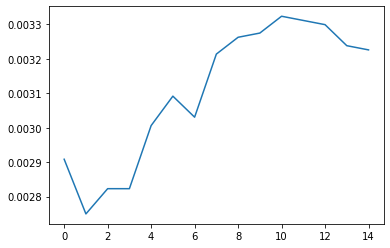

In [338]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [413]:
biases, embeddings = model.get_item_representations()

In [414]:
model.item_biases *= 0.0

In [415]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [416]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [ ]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [418]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [ ]:
with open(DATA_DIR + "recommendations.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")